# A vanilla VAE implementation for MNIST

In [1]:
import os
import sys
import time
import random
import tempfile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

In [2]:
%matplotlib inline
plt.ioff()

In [3]:
latent_dim = 10
dim = 784

dev = torch.device('cuda:1')

## Load MNIST:

In [4]:
mnist_dataset = datasets.MNIST(tempfile.gettempdir(), train=True, download=True,
                       transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]))

## Define functions:

In [5]:
def make_encoder(dim, latent_dim):
    encoder = nn.Sequential(
        nn.Linear(dim, 500),
        nn.Tanh(),
        nn.Linear(500, 2*latent_dim),
    )
    
    return encoder

In [6]:
def make_decoder(dim, latent_dim):
    decoder = nn.Sequential(
        nn.Linear(latent_dim, 500),
        nn.Tanh(),
        nn.Linear(500, 1000),
        nn.Tanh(),
        nn.Linear(1000, dim),
        nn.Sigmoid(),
    )
    
    return decoder

In [7]:
def compute_KL_divergence(mu, log_var):
    KL = -torch.mean(0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=1))
    
    return KL

In [8]:
def compute_reconstruction_error(x, x_p):
    return -torch.mean(torch.sum(x*torch.log(x_p) + (1.0-x)*torch.log(1.0-x_p), dim=1))
    # return torch.mean(torch.sum((x - x_p)**2, dim=1))

In [9]:
fixed_z = np.random.randn(16, latent_dim)
fixed_z = torch.Tensor(fixed_z).to(dev)
def sample_digits(model):
    imas = model(fixed_z).detach().cpu().numpy()
    imas = imas.reshape([16, 28, 28])
    return imas

In [10]:
def create_animation_digits(intermediate_results):
    
    fig, ax_arr = plt.subplots(4, 4, figsize=(12, 12))
    
    imas = intermediate_results[0]
    plots = 16*[0]
    
    for i in range(16):
        plots[i] = ax_arr[i//4, i%4].imshow(imas[i], cmap='gray', vmin=0.0, vmax=1.0)
        ax_arr[i//4, i%4].axis('off')
    
    
    def update_scat(i):
        imas = intermediate_results[i]
        for i in range(16):
            plots[i].set_data(imas[i])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

## Train VAE:

In [11]:
batch_size = 200
epochs = 100

In [12]:
encoder, decoder = make_encoder(dim, latent_dim).to(dev), make_decoder(dim, latent_dim).to(dev)

In [13]:
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [14]:
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

In [15]:
loss = []
KL = []


intermediate_results = []

# Train loop
t0 = time.time()
for e in range(epochs):

    cum_loss = 0
    cum_KL = 0
    count = 0
    
    for images, _ in train_loader:
        images = images.view(images.shape[0], -1)

        images = images.to(dev, non_blocking=True)

        optimizer.zero_grad()

        infer = encoder(images)
        
        mu, log_var = infer[:, :latent_dim], infer[:, latent_dim:]
        
        z = mu + torch.sqrt(torch.exp(log_var)) * torch.randn_like(mu)
        
        x_p = decoder(z)
        
        _RE = compute_reconstruction_error(images, x_p)
        _KL = compute_KL_divergence(mu, log_var)
        
        _loss = _RE + _KL


        cum_loss += _loss.item()
        cum_KL += _KL.item()
        count += 1

        _loss.backward()
        optimizer.step()

    loss.append(cum_loss/count)
    KL.append(cum_KL/count)
    intermediate_results.append(sample_digits(decoder))
        
    if e%5 == 4:
        print('epoch: {}, at time: {:.2f}, loss: {:.3e}, KL: {:.3e}'.format(e, time.time()-t0, loss[-1], KL[-1]))

epoch: 4, at time: 45.64, loss: 1.100e+02, KL: 1.759e+01
epoch: 9, at time: 91.17, loss: 1.050e+02, KL: 1.836e+01
epoch: 14, at time: 136.25, loss: 1.027e+02, KL: 1.870e+01
epoch: 19, at time: 181.14, loss: 1.012e+02, KL: 1.894e+01
epoch: 24, at time: 225.81, loss: 1.001e+02, KL: 1.909e+01
epoch: 29, at time: 270.42, loss: 9.923e+01, KL: 1.919e+01
epoch: 34, at time: 315.11, loss: 9.857e+01, KL: 1.930e+01
epoch: 39, at time: 359.84, loss: 9.796e+01, KL: 1.934e+01
epoch: 44, at time: 404.70, loss: 9.742e+01, KL: 1.941e+01
epoch: 49, at time: 450.42, loss: 9.710e+01, KL: 1.948e+01
epoch: 54, at time: 496.29, loss: 9.672e+01, KL: 1.955e+01
epoch: 59, at time: 542.20, loss: 9.648e+01, KL: 1.957e+01
epoch: 64, at time: 587.76, loss: 9.610e+01, KL: 1.963e+01
epoch: 69, at time: 633.21, loss: 9.583e+01, KL: 1.969e+01
epoch: 74, at time: 678.64, loss: 9.564e+01, KL: 1.971e+01
epoch: 79, at time: 724.34, loss: 9.530e+01, KL: 1.974e+01
epoch: 84, at time: 769.27, loss: 9.519e+01, KL: 1.978e+01
e

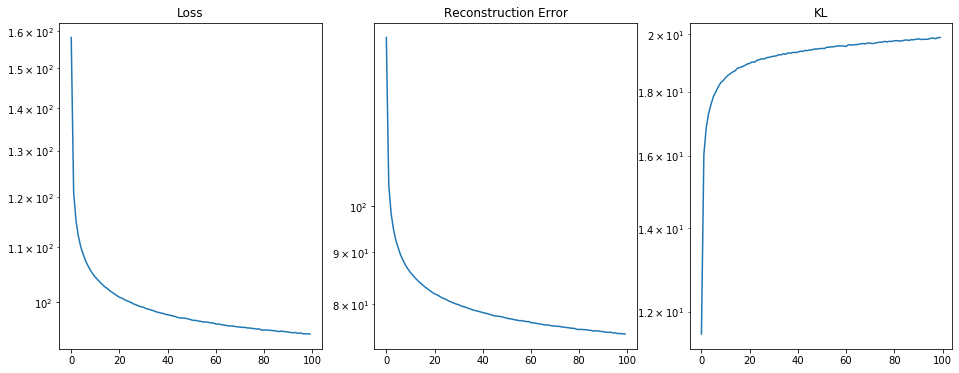

In [16]:
fig, ax_arr = plt.subplots(1, 3, figsize=(16, 6))

ax_arr[0].plot(loss)
ax_arr[0].set_yscale('log')
ax_arr[0].set_title('Loss')


ax_arr[1].plot(np.array(loss)-np.array(KL))
ax_arr[1].set_yscale('log')
ax_arr[1].set_title('Reconstruction Error')


ax_arr[2].plot(KL)
ax_arr[2].set_yscale('log')
ax_arr[2].set_title('KL')

plt.show()

In [17]:
ani = create_animation_digits(intermediate_results)

In [18]:
HTML(ani.to_html5_video())

In [19]:
ima = x_p.detach().cpu().numpy()[5]

In [20]:
orig = images.detach().cpu().numpy()[5]

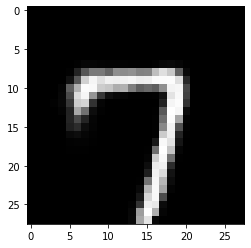

In [21]:
plt.figure()
plt.imshow(ima.reshape(28, 28), cmap='gray')
plt.show()

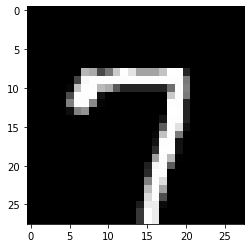

In [22]:
plt.figure()
plt.imshow(orig.reshape(28, 28), cmap='gray')
plt.show()

In [23]:
orig

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
ima

array([1.43700600e-12, 9.97951288e-13, 9.04612323e-13, 8.16337828e-13,
       1.17485177e-12, 8.97124334e-13, 1.46770356e-12, 1.67109143e-12,
       1.29534035e-12, 1.28531127e-12, 8.21290139e-13, 8.70353919e-13,
       2.04913708e-11, 9.19948796e-13, 3.66112002e-12, 4.25162211e-10,
       1.08642349e-12, 9.57221390e-13, 1.67839679e-12, 1.59404044e-12,
       1.29563927e-12, 1.00068456e-12, 8.73531987e-13, 1.15416910e-12,
       9.89505569e-13, 1.37175015e-12, 1.07509216e-12, 9.78806012e-13,
       1.42807662e-12, 1.30811703e-12, 9.96209300e-13, 7.50001569e-13,
       5.35826104e-13, 1.57958802e-09, 9.96902214e-11, 4.18573093e-10,
       4.42220809e-11, 1.21852077e-11, 1.41760548e-10, 4.39921415e-08,
       6.20588594e-08, 1.48534662e-09, 2.55629573e-10, 2.88889512e-09,
       2.19469234e-10, 2.93769703e-10, 1.29418823e-10, 1.72571527e-10,
       1.75840473e-12, 5.60968982e-14, 2.34924658e-09, 3.56524671e-10,
       8.87071666e-13, 9.88079735e-13, 1.82034726e-12, 1.13462733e-12,
      

In [25]:
fixed_z

tensor([[-7.6722e-01,  6.1252e-01,  1.9110e+00,  2.6841e-01,  3.4141e-01,
         -4.9423e-01,  1.0225e+00,  2.4713e-02,  2.5279e-01, -1.1228e-01],
        [-2.0298e+00, -1.4800e+00,  1.8778e-01, -6.0343e-01,  1.6373e+00,
          6.8312e-02,  2.5429e-01, -7.1537e-01, -5.3414e-02,  8.2167e-01],
        [ 4.7556e-01,  7.1389e-01, -7.4806e-01,  8.4732e-01,  2.7259e-01,
         -5.6658e-01,  5.5258e-01,  1.7926e+00, -9.8219e-01,  2.8848e-01],
        [-2.3631e-01, -1.7417e+00, -1.7571e-01,  6.5027e-01,  4.3946e-01,
          1.1256e+00,  1.2765e+00,  3.1909e-01,  1.6589e+00,  1.0203e-01],
        [-3.4349e-01, -3.6586e-01,  9.6751e-01,  9.0353e-03,  1.6295e+00,
          1.0071e+00, -2.0295e-01, -4.0302e-01,  2.0657e+00,  4.3295e-01],
        [-2.6964e-01, -1.0499e+00,  2.9890e-01, -3.0529e-01,  2.8405e-02,
         -3.4135e-01,  2.3350e+00, -7.3538e-01, -5.9029e-01, -5.6670e-01],
        [-8.0784e-01, -5.2798e-01, -3.7040e-01, -2.5931e-01, -2.1481e-01,
          1.3870e+00,  2.4941e-0